In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
import os

In [2]:
# Configuration
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 2

In [3]:
# Dataset paths
train_path = os.path.join('DATA_SET', 'Train')
valid_path = os.path.join('DATA_SET', 'Validation')
test_path = os.path.join('DATA_SET', 'Test')

In [4]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_directory(
    valid_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10906 images belonging to 2 classes.


In [5]:
# Load MobileNetV2 base model
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                         include_top=False,
                         weights='imagenet')

In [6]:
# Freeze base layers except last 30
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [7]:
# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [8]:
# Learning rate scheduler
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

optimizer = Adam(learning_rate=lr_schedule)


In [9]:
# Compile model
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [10]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [11]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stop]
)

Epoch 1/2


C:\Users\vivek\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4376/4376 ━━━━━━━━━━━━━━━━━━━━ 13395s 3s/step - accuracy: 0.8922 - loss: 0.4709 - val_accuracy: 0.9020 - val_loss: 0.3855
Epoch 2/2
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 13047s 3s/step - accuracy: 0.9384 - loss: 0.1660 - val_accuracy: 0.9244 - val_loss: 0.2577


In [12]:
# Evaluate model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

341/341 ━━━━━━━━━━━━━━━━━━━━ 584s 2s/step - accuracy: 0.8752 - loss: 0.5045
Test Accuracy: 78.42%


In [ ]:
# Save the entire model in the modern .keras format
model.save('deepfake_mobilenetv2_model.keras')

# Save just the model weights (optional)
model.save_weights('deepfake_mobilenetv2.weights.h5')

print("Model and weights saved successfully!")


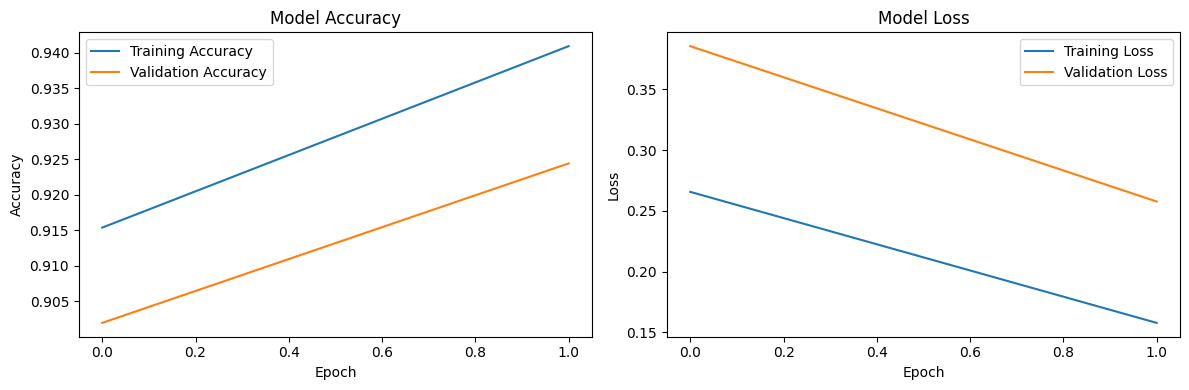

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


341/341 ━━━━━━━━━━━━━━━━━━━━ 601s 2s/step


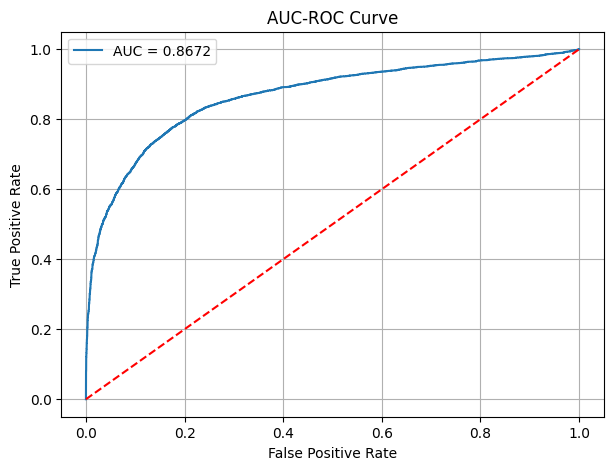

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

# Reset generator and predict probabilities
test_generator.reset()
y_pred_prob = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_true = test_generator.classes

# Compute AUC-ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
auc = roc_auc_score(y_true, y_pred_prob)

# Plot AUC-ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


341/341 ━━━━━━━━━━━━━━━━━━━━ 493s 1s/step


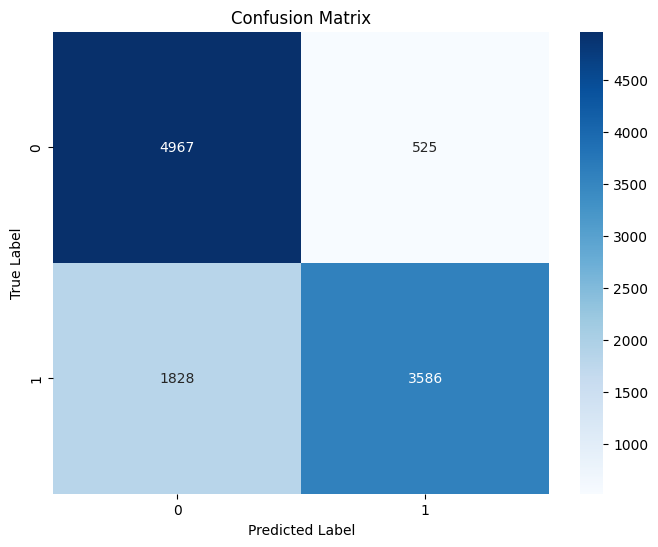

Classification Report:
              precision    recall  f1-score   support

        Real       0.73      0.90      0.81      5492
        Fake       0.87      0.66      0.75      5414

    accuracy                           0.78     10906
   macro avg       0.80      0.78      0.78     10906
weighted avg       0.80      0.78      0.78     10906



In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_confusion_matrix():
    # Get predicted class labels
    test_generator.reset()
    y_pred_prob = model.predict(test_generator, steps=len(test_generator), verbose=1)
    y_pred = (y_pred_prob > 0.5).astype(int)

    y_true = test_generator.classes

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Print classification metrics
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))

# Call the function
plot_confusion_matrix()


In [ ]:
#Visualize Test Predictions
import random
import matplotlib.pyplot as plt

def plot_prediction_grid(generator, num_images=10):
    plt.figure(figsize=(20, 10))

    # Get a random batch from the generator
    images, true_labels = next(generator)

    # Make predictions on the batch
    predictions = model.predict(images)

    for idx in range(min(num_images, len(images))):
        plt.subplot(2, 5, idx + 1)
        plt.imshow(images[idx])
        
        pred_label = "Fake" if predictions[idx] > 0.5 else "Real"
        true_label = "Fake" if true_labels[idx] > 0.5 else "Real"

        # Color title based on prediction match
        color = 'green' if pred_label == true_label else 'red'
        plt.title(f'Pred: {pred_label}\nTrue: {true_label}', color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions on test set
print("Visualizing predictions on test data:")
plot_prediction_grid(test_generator)


In [ ]:
#Predict on a Specific Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

IMG_HEIGHT, IMG_WIDTH = 224, 224  # Defined size for MobileNetV2 input

def prepare_image(image_path):
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_and_visualize_sample(image_path):
    img_array = prepare_image(image_path)
    prediction = model.predict(img_array)[0][0]

    # Display image
    plt.imshow(load_img(image_path))
    plt.axis('off')

    label = 'Fake' if prediction > 0.5 else 'Real'
    confidence = prediction if prediction > 0.5 else 1 - prediction

    plt.title(f"Predicted: {label} ({confidence:.2%} confidence)")
    plt.show()

    print("\nDetailed Prediction:")
    print(f"Raw prediction: {prediction:.4f}")
    print(f"Predicted class: {label}")
    print(f"Confidence: {confidence:.2%}")

# Example usage
image_path = "sreevardhan.jpg"
predict_and_visualize_sample(image_path)


In [ ]:
#Save Model Performance Metrics
import json

# Evaluate model if not already done
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)

performance_metrics = {
    'test_accuracy': float(test_accuracy),
    'test_loss': float(test_loss),
    'final_train_accuracy': float(history.history['accuracy'][-1]),
    'final_train_loss': float(history.history['loss'][-1]),
    'final_val_accuracy': float(history.history['val_accuracy'][-1]),
    'final_val_loss': float(history.history['val_loss'][-1])
}

with open('model_metrics.json', 'w') as f:
    json.dump(performance_metrics, f, indent=4)

print("Performance metrics saved to model_metrics.json")
